<a href="https://colab.research.google.com/github/duvancatan/Time_Series_UdeA/blob/main/7_Temp_Med_Forecast_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

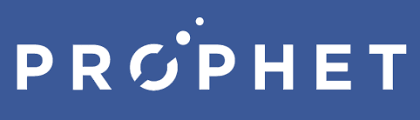

# **Metodología : PROPHET**
Prophet es un procedimiento para pronosticar datos de series temporales basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos faltantes y a los cambios en la tendencia y, por lo general, maneja bien los valores atípicos.

## **Características**:
1. Preciso y rápido: Prophet es preciso y rápido. Se utiliza en muchas aplicaciones de Facebook para producir pronósticos confiables para la planificación y el establecimiento de objetivos.
2. Completamente automático: Prophet es completamente automático. Obtendremos un pronóstico razonable sobre datos confusos sin esfuerzo manual.
3. Pronósticos ajustables: Prophet produce pronósticos ajustables. Incluye muchas posibilidades para que los usuarios modifiquen y ajusten los pronósticos. Podemos utilizar parámetros interpretables por humanos para mejorar el pronóstico agregando nuestro conocimiento del dominio.
4. Disponible en R o Python: podemos implementar el procedimiento Prophet en R o Python.
5. Maneja bien las variaciones estacionales: Prophet se adapta a la estacionalidad con múltiples períodos.
6. Robusto ante valores atípicos: es robusto ante valores atípicos. Maneja los valores atípicos eliminándolos.
7. Robusto ante datos faltantes: Prophet es resistente a datos faltantes.

## **DATOS : METEOSTAT**
La biblioteca Meteostat Python proporciona acceso sencillo a datos meteorológicos y climáticos abiertos mediante Pandas. Las observaciones y estadísticas históricas se obtienen de la interfaz de datos masivos de Meteostat y consisten en datos proporcionados por diferentes interfaces públicas, la mayoría de las cuales son gubernamentales. Entre las fuentes de datos se encuentran servicios meteorológicos nacionales como la Administración Nacional Oceánica y Atmosférica (NOAA) y el servicio meteorológico nacional de Alemania (DWD).

## Instalación y carga de librerías

In [ ]:
!pip install meteostat
!pip install prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from meteostat import Stations, Daily
from datetime import datetime
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# **Descripción :**

La metodología Prophet es planteada originalmente por Taylor y Letham (2018) [1]. Se utilizan tres componentes en el modelo: tendencia, estacionalidad y efecto de vacaciones (*hollidays*).

$$Y_t=g_t+s_t+ h_t+e_t$$

*   $g_t$ es la función de tendencia que modela cambios no periódicos en el valor de la serie de tiempo.
*   $s_t$ representa cambios periódicos (por ejemplo, estacionalidad semanal y anual).
*  $h_t$ representa los efectos de las vacaciones.

La especificacion Prophet es una clase de modelos de regresión con suavizadores (*smoothers*) potencialmente no lineales aplicados a la regresores

[1] Taylor, S. & Letham, Benjamin (2018). Forecasting at Scale. *The American Statistician*. (72)1, 37-45. https://doi.org/10.1080/00031305.2017.1380080

### ***Paso 1 :*** Obtener los datos de meteostat, llevarlos un dataframe y filtrar para obtener la información de Medellín.

In [ ]:
# Buscar estaciones por nombre de ciudad
stations = Stations()
stations = stations.nearby(6.2518400, -75.5635900) # Coordenadas aproximadas de la Medellín (https://www.antipodas.net/coordenadaspais/colombia/medellin.php)
station = stations.fetch(1) # Obtener la estación más cercana

In [ ]:
station
#Longitud: -75.5635900
#Latitud: 6.2518400

In [ ]:
# Obtener datos diarios para la estación más cercana a la Medellín
#start = datetime(2020, 1, 1)
start = datetime(2022, 1, 1)
end = datetime(2024, 5, 6)
data = Daily(station, start,end)
data = data.fetch()

In [ ]:
# Mostrar todos los datos
data

## **Variables:**

- ***tavg***: Temperatura media o promedio diaria.
- ***tmin***: Temperatura mínima registrada en un día.
- ***tmax***: Temperatura máxima registrada en un día.
- ***prcp***: Precipitación total en milímetros o pulgadas para el día. Incluye lluvia, nieve, granizo, etc.
- ***snow***: Cantidad de nieve caída, generalmente en milímetros o centímetros equivalentes de agua.
- ***wdir***: Dirección promedio del viento en grados, donde 0 grados significa - viento soplando desde el norte.
- ***wspd***: Velocidad promedio del viento en kilómetros por hora o millas por hora.
- ***wpgt***: Racha de viento máxima, que es la velocidad más alta alcanzada por un golpe de viento.
- ***pres***: Presión atmosférica al nivel de la estación.
- ***tsun***: Duración de la insolación, que es el tiempo durante el cual un lugar recibe luz solar directa, medido en minutos u horas.

### ***Paso 2 :*** Antes de suavizar los datos, es importante verificar la presencia de datos nulos y decidir cómo manejarlos.

In [ ]:
# Verificar datos nulos
print(data.isnull().sum())
# Suavizar los datos con un promedio móvil de 7 días
data_suavizada = data.rolling(window=7).mean()
# Suavizar los datos con un promedio móvil de 14 días
data_suavizada2 = data.rolling(window=14).mean()

In [ ]:
# Configurando el tamaño del gráfico
plt.figure(figsize=(15, 15))

# Lista de variables para iterar y graficar
variables = ['tavg', 'tmin', 'tmax', 'prcp']

for i, var in enumerate(variables, 1):
    plt.subplot(4, 1, i)
    plt.plot(data.index, data[var], label=f'{var} Original', color='skyblue', alpha=0.6)
    plt.plot(data_suavizada.index, data_suavizada[var], label=f'{var} 7 days rolling mean', color='navy', alpha=0.8)
    plt.plot(data_suavizada2.index, data_suavizada2[var], label=f'{var} 14 days rolling mean', color='blue', alpha=0.8)
    plt.title(var.upper())
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()

plt.tight_layout()
plt.show()

### ***Paso 3 :*** Preparar la información para el modelo. Se trabajan con dos columnas: **"ds"**, que indica la marca de tiempo, y la columna **"y"** que es la variable que se va a descomponer y pronosticar.

**La estructura (nombres de las columnas) es necesaria para trabajar con Prophet.**

In [ ]:
# Estructurar las columnas
df_prophet = data.reset_index().rename(columns={'time': 'ds', 'tavg': 'y'})

# Limitar el pronóstico a umbrales
df_prophet['cap'] = df_prophet['y'].max() + 2
df_prophet['floor'] = df_prophet['y'].min() - 2

In [ ]:
df_prophet

### **Tipos de growth :**
1. **Linear**: El crecimiento lineal es el tipo más básico de crecimiento y supone un aumento constante en la tendencia a lo largo del tiempo.

2. **Logistic**: El crecimiento logístico modela situaciones en las que el crecimiento tiende a estabilizarse a medida que se alcanza un límite superior o inferior. Es útil para modelar fenómenos que exhiben un crecimiento inicial rápido seguido de una desaceleración.

3. **Exponential**: El crecimiento exponencial es un tipo de crecimiento en el que la tasa de crecimiento aumenta o disminuye exponencialmente con el tiempo.

4. **Saturating**: Similar al crecimiento logístico, el crecimiento saturante modela situaciones en las que una serie temporal alcanza un límite superior o inferior y se estabiliza a medida que se acerca a ese límite.

In [ ]:
# Inicializar el modelo de Prophet con tendencia de crecimiento logístico (linear, logistic, exponential, saturating)
m = Prophet(growth='logistic', yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True,
            changepoint_prior_scale=0.05)

# Ajustar el modelo con los datos históricos
m.fit(df_prophet)

# Crear un DataFrame para las predicciones futuras, asumiendo 180 días hacia adelante
future = m.make_future_dataframe(periods=180)
future['cap'] = df_prophet['cap'].max()  # la capacidad sigue siendo la misma
future['floor'] = df_prophet['floor'].min()  # el suelo sigue siendo el mismo

# Realizar las predicciones
forecast = m.predict(future)

# Visualizar las predicciones
fig1 = m.plot(forecast)

### **Añadir puntos de quiebre**

Prophet por defecto seleccionará automáticamente 25 changepoints ubicados en los primeros 80% de la serie temporal. La selección de estos puntos se basa en cambios potenciales en la tendencia de los datos históricos. Esto significa que los últimos 20% de los datos no tendrán changepoints automáticamente.

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### **Ajuste de *changepoint_prior_scale***

El parámetro *changepoint_prior_scale* determina la flexibilidad de los changepoints seleccionados automáticamente:

Un valor más alto significa que el modelo es más flexible y puede cambiar más rápidamente.

Un valor más bajo significa que el modelo es más rígido y cambia más lentamente.
Aquí te muestro cómo ajustar la escala del changepoint para controlar la flexibilidad de la tendencia:

In [ ]:
# Modelo con mayor flexibilidad
m_flexible = Prophet(changepoint_prior_scale=0.5)
m_flexible.fit(df_prophet)

# Modelo con menor flexibilidad
m_rigid = Prophet(changepoint_prior_scale=0.01)
m_rigid.fit(df_prophet)

# Preparar futuro DataFrame y hacer predicciones para ambos modelos
future = m_flexible.make_future_dataframe(periods=180)
forecast_flexible = m_flexible.predict(future)
forecast_rigid = m_rigid.predict(future)

In [ ]:
# Fechas en el eje x para ambos forecast
dates = future['ds']

# Extraer las predicciones de yhat para ambas versiones del modelo
y_flexible = forecast_flexible['yhat']
y_rigid = forecast_rigid['yhat']

plt.figure(figsize=(15, 5))
plt.plot(dates, y_flexible, label='Flexible Forecast', color='blue')
plt.plot(dates, y_rigid, label='Rigid Forecast', color='red')
plt.fill_between(dates, forecast_flexible['yhat_lower'], forecast_flexible['yhat_upper'], color='blue', alpha=0.2)
plt.fill_between(dates, forecast_rigid['yhat_lower'], forecast_rigid['yhat_upper'], color='red', alpha=0.2)

# Añadir los datos reales al gráfico para referencia
plt.scatter(df_prophet['ds'], df_prophet['y'], color='black', s=10, label='Real Data')

plt.title('Comparison of Flexible vs Rigid Forecast for Average Temperature Mexico City')
plt.xlabel('Date')
plt.ylabel('Temperature (tavg)')
plt.legend()
plt.tight_layout()
plt.show()

### **Ajuste de *hollidays***

Para incluir el efecto *hollidays* o vacacional, primero debes crear un DataFrame que contenga estas fechas específicas. En este ejemplo usaremos las fechas de Semana Santa y las vacaciones de verano.

In [ ]:
# Ejemplo de fechas de Semana Santa y vacaciones de mitad de año para varios años
# Nota: Reemplaza estas fechas con las fechas exactas relevantes para tu análisis
holidays_data = {
  'holiday': ['Semana Santa', 'Semana Santa', 'Semana Santa','Semana Santa','Vacaciones Mitad Ano', 'Vacaciones Mitad Ano', 'Vacaciones Mitad Ano'],
  'ds': pd.to_datetime(['2021-04-04', '2022-04-17','2023-04-15','2024-04-15', '2021-06-15', '2022-06-15','2023-06-15']),
  'lower_window': -2, # La ventana alrededor de la festividad (e.g., Semana Santa comienza antes)
  'upper_window': 2,
}

holidays = pd.DataFrame(holidays_data)

In [ ]:
# Instanciar el modelo con el DataFrame de festividades
m = Prophet(holidays=holidays)

Además, se pueden añadir estacionalidades personalizadas, como una estacionalidad mensual, si crees que hay patrones recurrentes a lo largo del mes que podrían afectar a tu variable objetivo

In [ ]:
# Agregar estacionalidad mensual al modelo
m.add_seasonality(name='monthly', period = 30.5, fourier_order = 5)

El period se establece en 30.5 para reflejar la duración promedio de un mes, y el fourier_order controla la flexibilidad de la estacionalidad. Un fourier_order más alto permitirá que la estacionalidad capture cambios más rápidos.

In [ ]:
# Ajustar el modelo con los datos históricos
m.fit(df_prophet)

# Crear un DataFrame para las predicciones futuras
future = m.make_future_dataframe(periods=30)

# Realizar las predicciones
forecast = m.predict(future)

plt.figure(figsize=(15, 5))
# Visualizar las predicciones
fig1 = m.plot(forecast)
#fig2 = m.plot_components(forecast)

In [ ]:
# Imprimir las primeras filas del DataFrame de predicciones
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

### **Validación cruzada**

La validación cruzada en Prophet es una herramienta poderosa para entender cómo el modelo se desempeña a lo largo del tiempo, especialmente para series temporales donde las condiciones pueden cambiar.

La validación cruzada en Prophet se realiza generando predicciones para una secuencia de cortes en los datos históricos. Esto te permite evaluar cómo habría funcionado el modelo si se hubiera utilizado para predecir el futuro.

- ***initial***: La cantidad de datos iniciales utilizados para ajustar el modelo.
- ***period***: La distancia entre los puntos de inicio de corte sucesivos.
- ***horizon***: La longitud del periodo que se predice en cada corte.

In [ ]:
# Realizar validación cruzada
#df_cv = cross_validation(m, initial='1095 days', period='180 days', horizon='365 days')
df_cv = cross_validation(m, initial='300 days', period='40 days', horizon='90 days')
# Obtener métricas de rendimiento
df_p = performance_metrics(df_cv)
df_p

In [ ]:
# Obtener métricas de rendimiento
#df_p = performance_metrics(df_cv)
#print(df_p.head())

plt.figure(figsize=(15, 5))
# Visualizar el rendimiento usando MAPE
fig = plot_cross_validation_metric(df_cv, metric='mape')